## Run community detection experiments

Do this for algorithms:
* planted partition or SBM
* Louvain

And hopefully eADAGE & coexpression networks, if time...

In [1]:
import os

import numpy as np
import pandas as pd
import graph_tool.all as gt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns

from sample_nodes import (
    sample_degree_matched,
    sort_by_degree,
)

np.random.seed(42)
gt.seed_rng(42)

In [2]:
# relevant file paths
data_dir = './data'
processed_graph = os.path.join(data_dir, 'eadage_generic_graph.gt')

# script parameters
NUM_NODE_SAMPLES = 100 # number of degree-matched node samples for permutation test

In [3]:
G = gt.load_graph(processed_graph)
# make sure vertex/edge properties exist
print(G)
print(list(G.vp.keys()))
print(list(G.ep.keys()))

<Graph object, undirected, with 3477 vertices and 31556 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f5f38c80430>
['name', 'generic']
['weight']


In [4]:
# community detection using planted partition model
state = gt.PPBlockState(G)
state.multiflip_mcmc_sweep(beta=np.inf, niter=1000)

(-62639.41206195214, 2840780, 161389)

In [5]:
print('k = {}'.format(state.get_B()))

k = 64


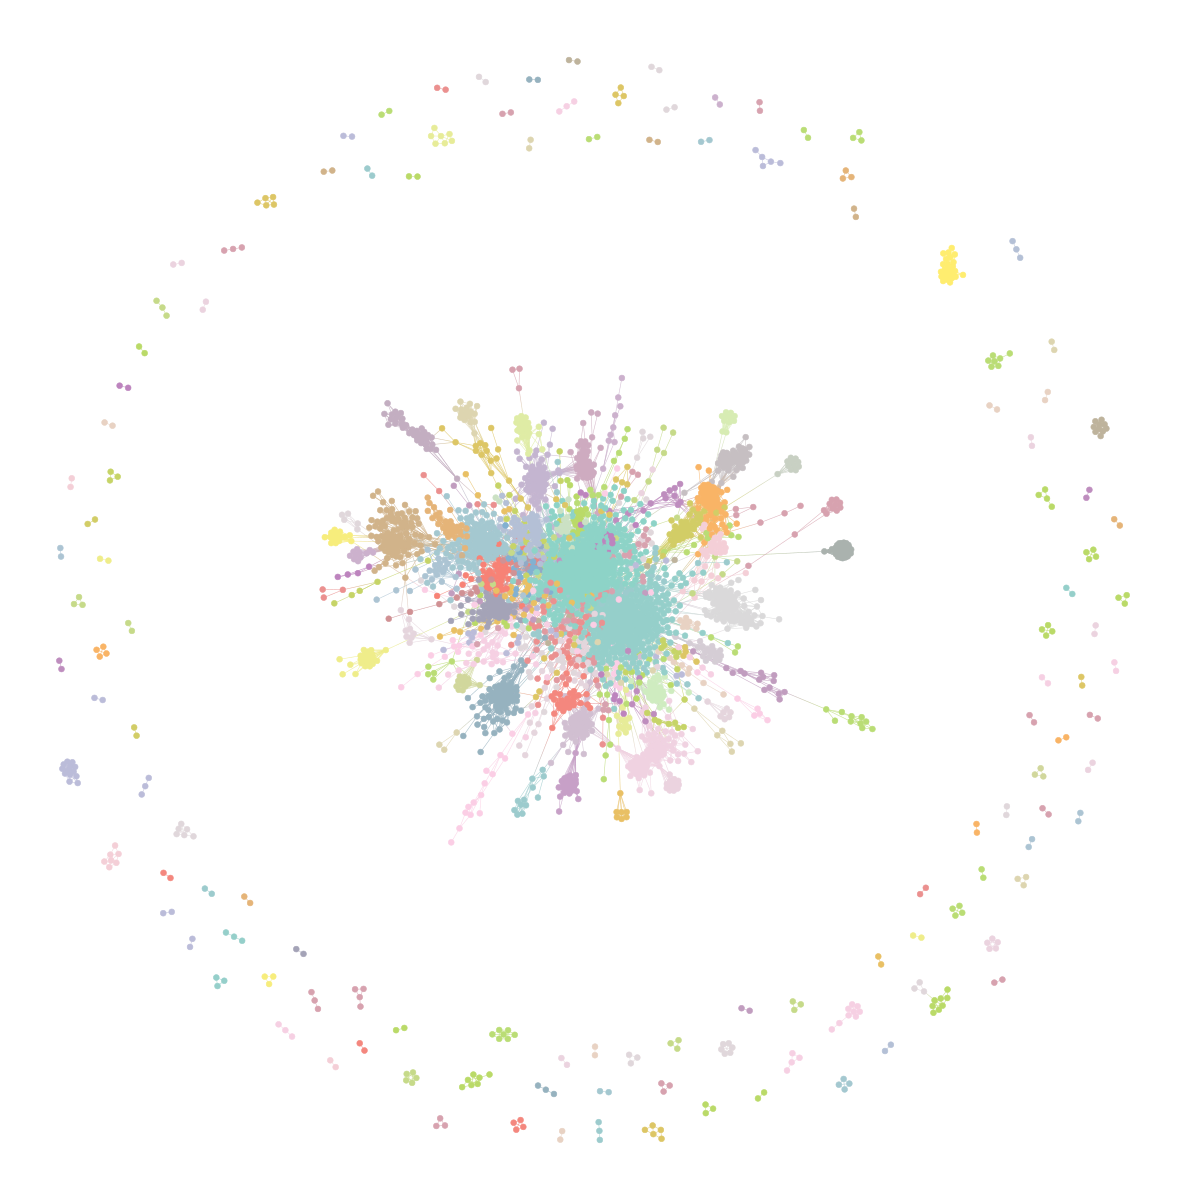

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f5ede2f2580, at 0x7f5f38c6f520>

In [6]:
state.draw()

In [7]:
# get dataframe mapping Pa genes to communities
def graph_state_to_df(G, state):
    labels = state.get_blocks().get_array()
    vs = G.get_vertices()
    names = [G.vp['name'][v] for v in vs]
    degrees = G.get_total_degrees(vs)
    is_generic = [G.vp['generic'][v] for v in vs]
    return pd.DataFrame({
        'gene': names,
        'label': labels,
        'degree': degrees,
        'is_generic': is_generic
    })

labels_df = graph_state_to_df(G, state)
print(len(labels_df.label.unique()))
labels_df.sort_values(by='degree', ascending=False).head()

64


,gene,label,degree,is_generic
26,PA4238,1969,209,0
29,PA4245,1969,201,0
30,PA4247,1969,192,0
79,PA4252,1969,181,0
27,PA4239,1969,180,0


In [8]:
# simultaneously sort nodes and degrees by degree, ascending
nodes, degrees, is_generic = sort_by_degree(labels_df.gene.values,
                                            labels_df.degree.values,
                                            labels_df.is_generic.values)

# sample a few times and add results to df
for it in range(NUM_NODE_SAMPLES):
    s_nodes, s_degrees, __ = sample_degree_matched(nodes, degrees, is_generic, num_bins=50)
    sampled = [1 if g in s_nodes else 0 for g in labels_df.gene]
    labels_df['sampled_{}'.format(it)] = sampled

labels_df.sort_values(by='degree', ascending=False).iloc[:5, :5]

,gene,label,degree,is_generic,sampled_0
26,PA4238,1969,209,0,0
29,PA4245,1969,201,0,0
30,PA4247,1969,192,0,0
79,PA4252,1969,181,0,0
27,PA4239,1969,180,0,0


In [9]:
generic_count_df = (
    labels_df.groupby('label').sum()
             .drop(columns=['degree'])
)
print(generic_count_df.shape)
generic_count_df.sort_values(by='is_generic', ascending=False).iloc[:5, :5]

(64, 101)


,is_generic,sampled_0,sampled_1,sampled_2,sampled_3
label,,,,,
537,55,6,8,11,11
1969,46,68,56,53,53
1306,45,8,7,12,10
591,25,10,4,4,7
3182,25,2,2,3,1


In [10]:
nonzero_counts_df = pd.DataFrame(
    [np.count_nonzero(generic_count_df, axis=0)],
    columns=generic_count_df.columns
)
nonzero_counts_df.iloc[:, :5]

,is_generic,sampled_0,sampled_1,sampled_2,sampled_3
0,48,57,55,55,56


Text(0.5, 1.0, 'Number of communities, generic genes vs. 100 degree-matched samples')

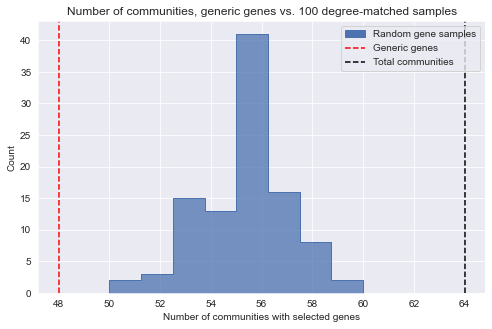

In [11]:
sns.set({'figure.figsize': (8, 5)})
sns.histplot(nonzero_counts_df.iloc[0, 1:].values, element='step')
line1 = plt.gca().axvline(x=nonzero_counts_df.iloc[0, 0],
                         linestyle='--', color='red')
line2 = plt.gca().axvline(x=state.get_B(),
                          linestyle='--', color='black')
plt.xlabel('Number of communities with selected genes')
plt.legend(handles=[mpatches.Patch(color=sns.color_palette()[0]), line1, line2],
           labels=['Random gene samples', 'Generic genes', 'Total communities'],
           loc='upper right')
plt.title('Number of communities, generic genes vs. {} degree-matched samples'.format(
    NUM_NODE_SAMPLES
))